<a href="https://colab.research.google.com/github/luiz200/8puzzle/blob/main/Estima%C3%A7%C3%A3o_do_PI_serial_x_paralelo_com_mutexes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tópicos especiais em sistemas embarcados - 2023.2
### Prof. Josenalde Barbosa de Oliveira - TADS@UFRN
# Atividade 1: desenvolver código com paradigma paralelo para estimar o número PI
Embora existam outras formas, para nosso objetivo o número PI pode ser aproximado pela série de N termos:

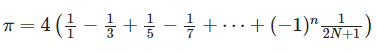

Um exemplo de código SERIAL (ou com apenas 1 thread, a thread main) para resolver o problema é:

```
double factor = 1.0;
double sum = 0.0;
for (i = 0; i < n; i++, factor = -factor) {
    sum += factor/(2i+1);
}
pi = 4.0sum;
Uma ideia de paralelização, é dividir os N termos entre T threads. Vamos assumir que N é divisível por T para uma distribuição balanceada (load balance). Seja

. Assim a thread(0) somará os termos na faixa
. A thread(1) somará os próximos
 termos, na faixa
. Ou seja, para a thread(q) a faixa será
. Se
 é par, o termo é POSITIVO, em caso contrário, é NEGATIVO.

Abaixo tem-se um exemplo de código com a variável SOMA compartilhada entre as T threads, sem controle à eventual seção crítica:

void* calcPartialPI sum(void* rank) {
    long my_rank = (long) rank; //typecast
    double factor;
    long long i;
    long long my_n = n/T;
    long long my_first i = my_n*my_rank;
    long long my_last i = my_first_i + my_n;

    if (my_first_i % 2 == 0) /* my first i is even */
        factor = 1.0;
    else /* my first i is odd */
        factor = -1.0;

    for (i = my_first_i; i < my_last_i; i++, factor = -factor) {
            sum += factor/(2i+1);
    }

    return NULL;
}

```


Pede-se:

# Configurações do meu notebook:
## Processador Intel® Core™ i5-1135G quad-core com 2 threads por core

a) PIparallel_1: Elaborar versão do código incluindo seção crítica controlada por MUTEX dentro do loop, tal como em: https://github.com/josenalde/parallel_programming_rtos/blob/main/src/pthread_count3s_mutex_1.cpp

In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <pthread.h>

#define NUM_THREADS 4 // Defina o número desejado de threads
#define NUM_TERMS 1000000 // Número total de termos na série

double soma = 0.0;
pthread_mutex_t mutex_soma;

void* calcularPIParcial(void* rank) {
    long meu_rank = (long)rank;
    double fator;
    long long i;
    long long meu_n = NUM_TERMS / NUM_THREADS;
    long long meu_primeiro_i = meu_n * meu_rank;
    long long meu_ultimo_i = meu_primeiro_i + meu_n;

    if (meu_primeiro_i % 2 == 0)
        fator = 1.0;
    else
        fator = -1.0;

    for (i = meu_primeiro_i; i < meu_ultimo_i; i++, fator = -fator) {
        double termo = fator / (2.0 * i + 1.0);

        pthread_mutex_lock(&mutex_soma);
        soma += termo;
        pthread_mutex_unlock(&mutex_soma);
    }

    return NULL;
}

int main() {
    pthread_t threads[NUM_THREADS];
    pthread_mutex_init(&mutex_soma, NULL);

    for (long rank_thread = 0; rank_thread < NUM_THREADS; rank_thread++) {
        pthread_create(&threads[rank_thread], NULL, calcularPIParcial, (void*)rank_thread);
    }

    for (long rank_thread = 0; rank_thread < NUM_THREADS; rank_thread++) {
        pthread_join(threads[rank_thread], NULL);
    }

    double pi = 4.0 * soma;
    printf("Valor estimado de PI: %lf\n", pi);

    pthread_mutex_destroy(&mutex_soma);
    return 0;
}

b) PIparallel_2: Elaborar versão do código incluindo seção crítica controlada por MUTEX fora do loop, com variável privada da soma de contribuição de cada thread, tal como em: https://github.com/josenalde/parallel_programming_rtos/blob/main/src/pthread_count3s_mutex_3.cpp E na folha 7 do slide arquivo setopics4.pdf disponível no SIGAA da disciplina.                                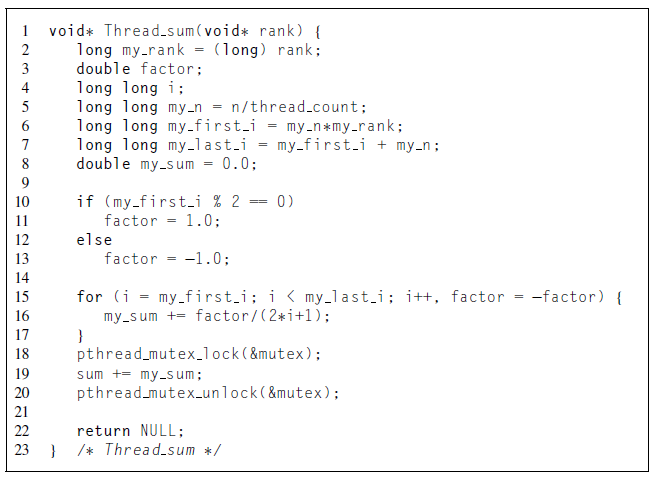

In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <pthread.h>

#define NUM_THREADS 4 // Defina o número desejado de threads
#define NUM_TERMS 1000000 // Número total de termos na série

double soma = 0.0;
pthread_mutex_t mutex_soma;

void* calcularPIParcial(void* rank) {
    long meu_rank = (long)rank;
    double fator;
    long long i;
    long long meu_n = NUM_TERMS / NUM_THREADS;
    long long meu_primeiro_i = meu_n * meu_rank;
    long long meu_ultimo_i = meu_primeiro_i + meu_n;
    double minha_soma = 0.0;

    if (meu_primeiro_i % 2 == 0)
        fator = 1.0;
    else
        fator = -1.0;

    for (i = meu_primeiro_i; i < meu_ultimo_i; i++, fator = -fator) {
        minha_soma += fator / (2.0 * i + 1.0);
    }

    pthread_mutex_lock(&mutex_soma);
    soma += minha_soma;
    pthread_mutex_unlock(&mutex_soma);

    return NULL;
}

int main() {
    pthread_t threads[NUM_THREADS];
    pthread_mutex_init(&mutex_soma, NULL);

    for (long rank_thread = 0; rank_thread < NUM_THREADS; rank_thread++) {
        pthread_create(&threads[rank_thread], NULL, calcularPIParcial, (void*)rank_thread);
    }

    for (long rank_thread = 0; rank_thread < NUM_THREADS; rank_thread++) {
        pthread_join(threads[rank_thread], NULL);
    }

    double pi = 4.0 * soma;
    printf("Valor estimado de PI: %lf\n", pi);

    pthread_mutex_destroy(&mutex_soma);
    return 0;
}

c) PIserial: Elaborar versão do código serial, sem paralelismo

In [ ]:
#include <stdio.h>

#define NUM_TERMS 1000000 // Número total de termos na série

int main() {
    double sum = 0.0;
    double factor = 1.0;

    for (long long i = 0; i < NUM_TERMS; i++, factor = -factor) {
        sum += factor / (2.0 * i + 1.0);
    }

    double pi = 4.0 * sum;
    printf("Estimated value of PI: %lf\n", pi);

    return 0;
}


d) criar tabela comparativa das letras a) e b) para o caso de 1 thread por core e de 2 threads por core. Exemplo: se a CPU tem 4 cores e até 2 threads por core, fazer para T=4 e T=8. Se tem 08 cores, fazer para T=8 e T=16. Na tabela deixar claro qual a CPU em que está rodando a aplicação. Se for no replit, informar apenas o número de threads. Pode ser usado o método presente nos arquivos acima para calcular o tempo, usando clock() A tabela resumo deve ter aparência como neste exemplo, comparando o caso SERIAL com os dois casos PARALELOS: formatar número de saída com 12 casas decimais, com cout.precision(12) e na hora de exibir uma variável, suponha x, fazer cout << fixed << x;

In [ ]:
#include <iostream>
#include <thread>
#include <vector>
#include <chrono>
#include <iomanip>
#include <mutex>

const int NUM_TERMS = 1000000; // Número total de termos na série

// Função para calcular PI de forma serial
double calcularPISerial() {
    double soma = 0.0;
    double fator = 1.0;

    for (long long i = 0; i < NUM_TERMS; i++, fator = -fator) {
        soma += fator / (2.0 * i + 1.0);
    }

    return 4.0 * soma;
}

// Função para calcular PI de forma paralela com mutex
double calcularPIParaleloComMutex(int numThreads) {
    double soma = 0.0;
    double fator = 1.0;
    std::vector<std::thread> threads(numThreads);
    std::mutex mtx;

    auto start = std::chrono::high_resolution_clock::now();

    for (int i = 0; i < numThreads; i++) {
        threads[i] = std::thread([&soma, &fator, i, numThreads, &mtx]() {
            long long my_n = NUM_TERMS / numThreads;
            long long my_first_i = my_n * i;
            long long my_last_i = my_first_i + my_n;
            double my_sum = 0.0;

            if (my_first_i % 2 == 0)
                fator = 1.0;
            else
                fator = -1.0;

            for (long long j = my_first_i; j < my_last_i; j++, fator = -fator) {
                my_sum += fator / (2.0 * j + 1.0);
            }

            std::lock_guard<std::mutex> lock(mtx);
            soma += my_sum;
        });
    }

    for (int i = 0; i < numThreads; i++) {
        threads[i].join();
    }

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duracao = end - start;

    return 4.0 * soma;
}

int main() {
    std::cout << std::fixed << std::setprecision(12);

    // Tabela de comparação
    std::cout << "Threads | Serial PI        | Paralelo (Mutex) PI | Tempo (s) (Média de 10 execuções)" << std::endl;
    std::cout << "-----------------------------------------------------------" << std::endl;

    for (int numThreads : {1, 2, 4, 8, 16}) {
        double piSerial = 0.0;
        double piParalelo = 0.0;
        double tempoTotal = 0.0;

        for (int i = 0; i < 10; i++) {
            auto inicioSerial = std::chrono::high_resolution_clock::now();
            piSerial = calcularPISerial();
            auto fimSerial = std::chrono::high_resolution_clock::now();
            std::chrono::duration<double> duracaoSerial = fimSerial - inicioSerial;

            auto inicioParalelo = std::chrono::high_resolution_clock::now();
            piParalelo = calcularPIParaleloComMutex(numThreads);
            auto fimParalelo = std::chrono::high_resolution_clock::now();
            std::chrono::duration<double> duracaoParalelo = fimParalelo - inicioParalelo;

            tempoTotal += duracaoParalelo.count();

            if (i == 0) {
                // Mostrar apenas a primeira execução para evitar saída excessiva
                std::cout << std::setw(7) << numThreads << " | " << std::setw(17) << piSerial << " | " << std::setw(20) << piParalelo << " | " << std::setw(24) << duracaoParalelo.count() << std::endl;
            }
        }

        std::cout << "-----------------------------------------------------------" << std::endl;
        std::cout << "Tempo Médio para " << numThreads << " Threads: " << tempoTotal / 10.0 << " segundos" << std::endl;
    }

    return 0;
}

 ./main
Threads | Serial PI        | Paralelo (Mutex) PI | Tempo (s) (Média de 10 execuções)
-----------------------------------------------------------
      1 |    3.141591653590 |       3.141591653590 |           0.061475115000
-----------------------------------------------------------
Tempo Médio para 1 Threads: 0.015734217100 segundos
      2 |    3.141591653590 |       3.141591653590 |           0.008074898000
-----------------------------------------------------------
Tempo Médio para 2 Threads: 0.003760784000 segundos
      4 |    3.141591653590 |       3.141591653590 |           0.007479238000
-----------------------------------------------------------
Tempo Médio para 4 Threads: 0.007830697900 segundos
      8 |    3.141591653590 |       3.141591653590 |           0.002885619000
-----------------------------------------------------------
Tempo Médio para 8 Threads: 0.008908811500 segundos
     16 |    3.141591653590 |       3.141591653590 |           0.005086339000
-----------------------------------------------------------
Tempo Médio para 16 Threads: 0.015583011300 segundos

**By: Luiz Felipe Henrique de Souza**